# Интерпретация экспериментальных данных
## Задачи

- **Построить спектрограммы**
- **Определить механические свойства виброизоляторов: коэффициенты упругости и вязкости в каждом из направлений для каждого виброизолятора. Подвижная масса *0.758 kg*.**

**Жесткость**: $$c = m (2 \pi \nu)^2 $$

**Вязкость**: $$\eta = m  \frac{a_{in}}{a_{out}} (2  \pi  \nu) $$

где: $m$ — *подвижная масса*, $\nu$ — *собственная частота*, $a_{in}$ — *входное ускорение (нагрузка)*,  $a_{out}$ — *выходное ускорение (отклик)*

## Эксперимент
**Внешний вид виброизолятора** | **Структура виброизолятора**
------------ | -------------
<img src="VIBRO_DATA/img/g2.PNG" alt="drawing" width="450"/>|<img src="VIBRO_DATA/img/damper.png" alt="drawing" width="450"/>


**Оснастка** | **Сетап**
------------ | -------------
<img src="VIBRO_DATA/img/GQ5RHMqNF6U.jpg" alt="drawing" width="450"/>| <img src="VIBRO_DATA/img/GogmLaroqI0.jpg" alt="drawing" width="450"/>

Резульаты вибрационных испытаний сохранены в папке `VIBRO_DATA/RESULT`.

`VIBRO_DATA/annotations.txt` содержатся аннотации к результатам.

## Посмотрим на содержимое папки `VIBRO_DATA`

In [ ]:
%ls

In [ ]:
%ls VIBRO_DATA

In [ ]:
%cat VIBRO_DATA/annotations.txt

In [ ]:
%ls VIBRO_DATA/RESULT/

Для вычисления механических свойств нужны только спектры амплитуды, согласно файлу с аннотациями эти файлы имеют маркировку *SA.F

Напишем функцию для выбора файлов по номеру виброизолятора, и величине нагрузки

In [ ]:
from typing import List
from glob import glob
import os

def select_files(id_: int, g: int, folder_path: str='VIBRO_DATA/RESULT/') -> List[str]:
    """
    get list of files of amplitude spectrum by shock absorber id
    """
    pattern_file_name = f'D{id_}G{g}*SA.F'
    
    # TODO Соедините путь к паке и шаблон имени, чтобы корректно заработала функция glob
    # https://docs.python.org/3/library/glob.html
    
    pattern_full_path = ???
    
    return glob(pattern_full_path)
    
    

In [ ]:
select_files(1, 1)

Посмотрим на любой из них.

После ознакомления с файлами в соседнем окошке стало понято что они представлеют собой таблицу: 11-ая строка это шапка таблицы, а сами значения начинаются с 12 строки и до распространяются до предпоследней строки файла. Поробуем прочитать ей как обычный файл и распарсить значения.

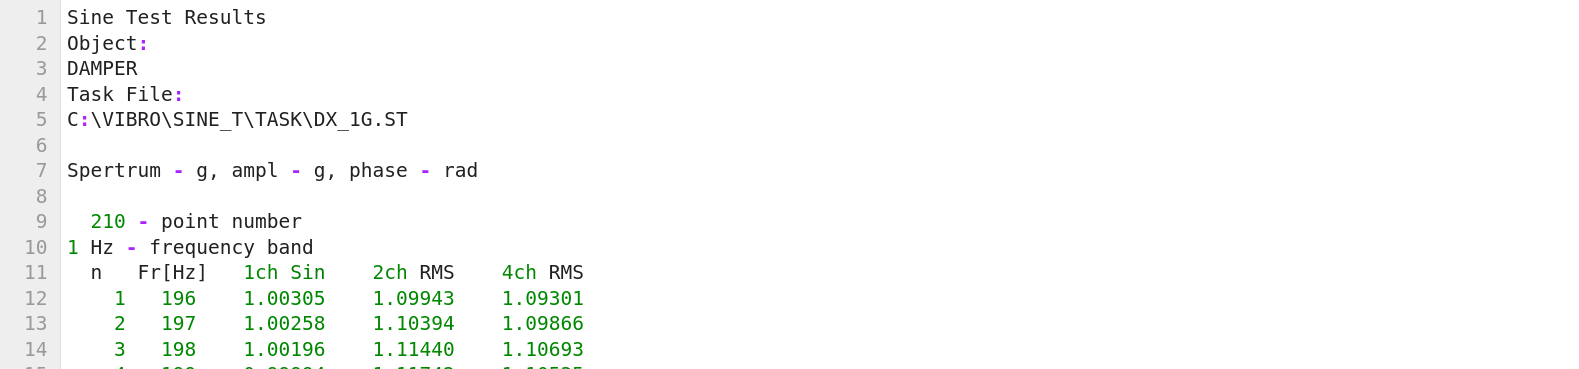

In [ ]:
file_name = select_files(1, 1)[0]
with open(file_name) as file:
    text = file.read().splitlines()

In [ ]:
len(text)

In [ ]:
text[11:20]

разобьем каждую строку по пробелам и сконвертируем строки в числа:

In [ ]:
text[11].split()

незадумываясь преващаем все во float, первую колонку сохранять не будем

In [ ]:
_, freq, ch1, ch2, ch3 = map(float, text[11].split())

In [ ]:
freq, ch1, ch2, ch3

соберем цикл, сохраним каждую колонку в отдельный список, засунем в функцию

In [ ]:
def get_data_from_file(file_name: str, start: int=11, stop: int=-1) -> tuple:
    """
    read given file path, and save second column as frequency, from third - as channels
    """
    data = []
                                                                            
    with open(file_name) as file:
        text = file.read().splitlines()
                                                                            
    for line in text[start:stop]:
        
        # TODO преобразуйте строку в список вещественных чисел и распакуйте
        _, *item = ???
        
        data.append(item)

    frequency, *channels = zip(*data)  # транспонируем список data и раскладываем колонки
    return frequency, channels                                                                        

In [ ]:
file_name = select_files(1, 1)[0]
freq, channels = get_data_from_file(file_name)

Построим спектрограмму, сразу обернем в функцию

In [ ]:
import matplotlib.pyplot as plt


def plot_spectre(frequency: tuple, channels: tuple, fname: str='') -> None:
    for i, channel in enumerate(channels):
        plt.plot(frequency, channel, '-', label=f'channel {i}')
    
    plt.title('Спекторограмма виброизолятора {fname}')
    plt.legend()
    plt.xlabel('Частота, Hz')
    plt.ylabel('Ускорение, g')

In [ ]:
plot_spectre(*get_data_from_file(file_name))

Видимо первый датчик - управляющий и был приклеен к столу. А желтый датчик кажется был приклеен не особо соосно: есть какой-то странный перегиб, видимо связанный с раскачиванием вибростенда, для упрощения, резонансом будем считать самый большой горб.

Посчитаем характеристики, вспомним формулы: 

**Жесткость**: $$c = m (2 \pi \nu)^2 $$

**Вязкость**: $$\eta = m  \frac{a_{in}}{a_{out}} (2  \pi  \nu) $$
где: $m$ — *подвижная масса*, $\nu$ — *собственная частота*, $a_{in}$ — *входное ускорение (нагрузка)*,  $a_{out}$ — *выходное ускорение (отклик)*

Зададим сразу массу в виде константы

In [ ]:
M = 0.758

Определим резонансную частоту

Сначала превратим все в numpy array, и выберем канал с самым жирным откликом

In [ ]:
import numpy as np

def get_max_response_channel(channels: tuple) -> np.ndarray:
    """
    takes a bunch of data columns, and returns one with strongest response
    """

    np_channels = np.array(channels)
    max_values_in_channels = np.max(np_channels, axis=1)
    idx_max_response_channel = np.argmax(max_values_in_channels)
    return np_channels[idx_max_response_channel]
    

убедимся что канал определён корректно

In [ ]:
freq, channels = get_data_from_file(file_name)
max_resp_channel = get_max_response_channel(channels)
plt.plot(freq, max_resp_channel)

Теперь найдем отклик и резонансную частоту

In [ ]:
def get_metrics(frequency: tuple, channels: tuple) -> tuple:
    """
    return resonant frequency, a_input, a_output
    """
    np_channels = np.array(channels)
    max_resp_channel = get_max_response_channel(np_channels)
    
    # находим индекс резонанса
    idx_of_resonance = np.argmax(max_resp_channel)  
    
    # берем срез по индексу по последней оси и выбираем наименьший отклик
    a_input = np.min(np.array(np_channels)[..., idx_of_resonance])    
    
    # TODO возьмите значения максимального отклика и резонансной частоты
    # из соотвествующих им последовательностей по вычесленному выше индексу idx_of_resonance
    a_output = ???
    resonant_freq = ???
           
    
    
    
    return resonant_freq, a_input, a_output

In [ ]:
get_metrics(*get_data_from_file(file_name))

что бы убедиться что все корректно, построим на графике, точка должна совпасть с экстремумом

In [ ]:
freq, channels = get_data_from_file(file_name)
resonant_freq, a_input, a_output = get_metrics(freq, channels)
max_resp_channel = get_max_response_channel(channels)

plt.plot(freq, max_resp_channel)
plt.plot(resonant_freq, a_output, 'o')

вычислим жесткость 

In [ ]:
def get_stiffness(frequency: float, mass: float) -> float:
    """
    calculate stiffnes coeficient by resonant frequency and sprung mass
    """
    # TODO воспользуйтесь формулой выше
    return ???


def get_viscous(frequency: float, mass: float, gain: float) -> float:
    """
    calculate viscous coeficient by resonant frequency, sprung mass and gain coefficient a_output/a_input
    """
    # TODO воспользуйтесь формулой выше
    return ???

In [ ]:
resonant_freq, a_iput, a_output = get_metrics(*get_data_from_file(file_name))

stiffness = get_stiffness(resonant_freq, M)
viscous = get_viscous(resonant_freq, M, a_output/a_input)

print(f'{stiffness/10**6=:.2f}, {viscous=:.2f}')

assert round(get_stiffness(1,1)) == 40
assert round(get_viscous(1,1,1)) == 6

Автоматизируем:

In [ ]:
id_ = 1

stiffness = {
    'A': [],
    'R': [], 
}
viscous = {
    'A': [],
    'R': [], 
}

plt.figure(figsize=(15,10))


for g in 1, 2, 3, 6:
    for path in select_files(id_, g):
        
        file_name = path.split('/')[-1]
        tag = file_name[4]  # буква отвечающая за направление
        
        freq, channels = get_data_from_file(path)
        max_response_channel = get_max_response_channel(channels)
        plt.plot(freq, max_response_channel, label=f'{tag=}, {g=}')
        
        resonant_freq, a_input, a_output = get_metrics(freq, channels)
        plt.plot(resonant_freq, a_output, 'o', label=f'{resonant_freq:.0f} Hz')
        
        # Добавляем метрики
        stiffness[tag].append(get_stiffness(resonant_freq, M))
        viscous[tag].append(get_viscous(resonant_freq, M, a_output/a_input))
        
plt.legend()

formatter = lambda x: f"{x / 10**6:.2f}"

text = []
text.append(f"Жесткость виброизолятора {id_}:")

for tag, direction in zip(('A', 'R'), ('осевом', 'радиальном')):
    text.append(f"в {direction} направлении: "
                f"{formatter(np.mean(stiffness[tag]))} ± "
                f"{formatter(np.std(stiffness[tag]))} 10*3 Н/мм")
           
plt.title(f'Спектрограммы испытаний виброизолятора {id_}')

print(*text, sep='\n')
    

### Задание со «звездочкой»

In [ ]:
# TODO Пишем функцию и агреггируем характеристики всех виброизоляторов в словарь